In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology




In [2]:
# INLEZEN
import numpy as np                 
from skimage import exposure       # image processing module to enhance contrast
from skimage import io, color
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import glob
try:
    import png  # backup when skimage backend fails 
except ImportError:
    pass
import os

np.seterr(all = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# FUNCTIONS
def read_RGB(IMAGEPATH, dims = (2448,2448,3)):
    """
        Function for reading RGB-bands from CLR.dat file
        
        PARAMETERS
        ----------
        
        IMAGEPATH : str
            absolute or relative path to the .dat file
        
        dims : tuple of ints (m, n, k)
            dimensions of the image 
    """
    f = open(IMAGEPATH, "r")
    a = np.fromfile(f, dtype=np.uint16)
    f.close()
    full = np.reshape(a, dims, order='F')
    return full

def read_SingleBand(IMAGEPATH, dims = (2448,2448), bandNr = 0):
    """
        Function for reading a specific band from a .dat file. Numbers go 
        from 0 to the number of bands in the file minus one (performance issue:
        this function reads the full image and subsequently slices the resulting
        array... performance gains might be obtained when reading selectively ...
        not a real issue at the time of implementation)
        
        PARAMETERS
        ----------
        
        IMAGEPATH : str
            absolute or relative path to the .dat file
        
        dims : tuple of ints (m, n)
            dimensions of the image 
            
        bandNr : int
            band to be read
        
    """
    f = open(IMAGEPATH, "r")
    a = np.fromfile(f, dtype=np.uint16)
    f.close()
    firstNr = (dims[0] * dims[1]) * bandNr
    length = (dims[0] * dims[1])
    full = np.reshape(a[firstNr : firstNr+length], dims, order='F')
    return full
    
def rescale(img, percentiles = None, to_uint8 = False):
    """
        Function that applies histogram stretching on an image, using the
        percentiles of the image histogram percentiles = None. --> to obtain a
        nice-looking image, rescaling is often important!
        
        If percentiles is an (a, b) tuple where a and b are floats, these values
        are used as upper and lower bounds for the stretching.
    """
    
    
    if percentiles is None:
            p2, p98 = np.percentile(img, (2, 98))
            percentiles = (p2, p98)
            
    img = exposure.rescale_intensity(img, in_range=percentiles)
    
    if img.dtype == "float64" and img.min() < 0.0:
        img = (img + 1)/2
        
    if to_uint8:
        img = img_as_ubyte(img, force_copy= True)
    return img
        
def save_as_PNG(img, fname , rescale_img = True, percentiles = None):
    """
        Function to save an image array as a png
        
        PARAMETERS
        ----------
        img : np.array
            (m, n, 3) numpy array of RGB values
    """
    if rescale_img:
        img = rescale(img, percentiles = percentiles, to_uint8 = True)
    try:
        io.imsave(fname, img)
    except Exception:
        png.from_array(img, 'RGB').save(fname)

def show_RGB(img, rescale_img = True, percentiles = None):
    if rescale_img:
        img = rescale(img, percentiles = percentiles)
    plt.imshow(np.array(img, dtype=float)/65536)

def gray_to_colormapped(img, cmap = "jet"):
    """
        Function to transform a grayscale image into an RGB image using a particular colormap
        typical applications are heat-map like images (using jet - colormap)
    """
    assert img.dtype == 'uint8', "datatype differs from uint8 when performing gray_to_colormapped"
    if cmap == "jet":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = 175-np.array(img/1.46, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap == "jet inv":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = np.array(img/1.46, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap == "fv/fm":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = np.array(img/3.5, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap =='gray':
        return img_as_ubyte(color.gray2rgb(img), force_copy=True)

def convert_folder_RGB(img_path_list, percentiles = None):
    cnt = 0
    for fname in img_path_list:
        try:
            img = read_RGB(fname)
            save_as_PNG(img, fname[:-3] + "png", rescale_img = True, percentiles = percentiles)
            cnt += 1
        except Exception:
            pass
    return cnt

def computeImage(image_dict, expression_str):
    """
    Computes the result of computing the expression in expression_str. The keys in image_dict are the variables names in the expression and the values the associated images
    
    TAKE CARE: uses some dirty tricks to avoid the need for tailor-made parser of expressions
    
    """
    d = image_dict
    for key in image_dict:
        expression_str = expression_str.replace(key, "d['" + key + "']")
    
    res = eval(expression_str)
    return res

def rescale_after_computation(im , rescale_method = "bound_to_unitInterval"):
    if rescale_method == "bound_to_unitInterval":
        pass
    elif rescale_method == "use_max":
        return im / np.max(im)
    else:
        return im

def parseExpression(expression, img_path):
    """
        Function to parse an expression and execute it at 'run time'. 
        
        Typical function for the DATimage_GUI --> should be relocated in future implementations
        
        RETURNS
        -------
        
        an (m, n) numpy array
        
    """
    fileTypes_dict = dict()
    # get list of bands
    tmp_expression = expression.replace(']', '] ')
    tmp_expression = ''.join([c for c in tmp_expression if not c in ['+', '-', '*', '/', '(', ')']])
    bands_lst = tmp_expression.split()
    
    # read bands from dat-files
    for band in bands_lst:
        try:
            referenceName = extractReferenceName(img_path)
            dat_file =  os.path.dirname(img_path)+ '/' + band[:3] + referenceName
            nr  = int(band[4])
            single_band = read_SingleBand(dat_file, bandNr = nr)
            fileTypes_dict[band.strip()] = np.array(single_band, dtype = float)
        except Exception as e:
            print("problem during parsing of band (may be ignored if the printed value is not a band)", band, e.__str__())
        
    computed = computeImage(fileTypes_dict, expression)
    computed[np.isnan(computed)] = 0
    computed[np.isinf(computed)] = 0
    return computed

def extractReferenceName(img_path):
    baseName = os.path.basename(img_path)
    return baseName[3:]

In [4]:
image_1 = 'D:/2024_Marten-Thesis/20240314_Spectral_RGB_CLR/CLR_E3515P7709N0001_20240314.DAT'
image_1 = rescale(read_RGB(image_1), percentiles = None, to_uint8=True)
image_2 = 'D:/2024_Marten-Thesis/20240314_Spectral_RGB_CLR/CLR_E3515P7710N0001_20240314.DAT'
image_2 = rescale(read_RGB(image_2), percentiles = None, to_uint8=True)

In [5]:
import glob
file_list = sorted(glob.glob('D:/2024_Marten-Thesis/20240314_Spectral_RGB_CLR/*.DAT'))


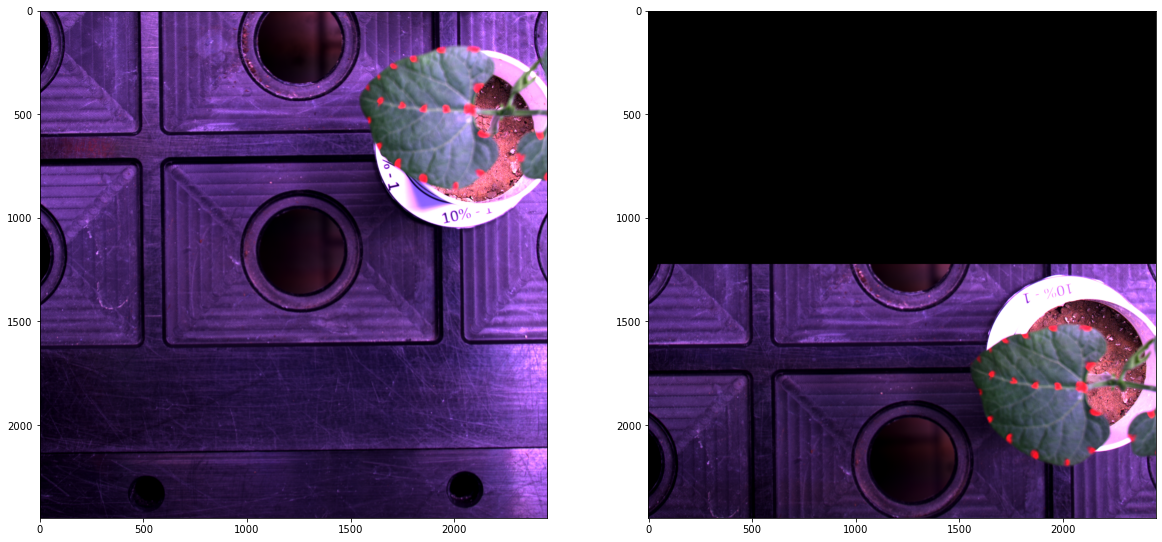

In [6]:
i = 2
image_1 = rescale(read_RGB(file_list[i]), percentiles = None, to_uint8=True)
image_2 = rescale(read_RGB(file_list[i+12]), percentiles = None, to_uint8=True)
image_2[0:image_2.shape[0]//2,:,:] = 0

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(image_1)
plt.subplot(1,2,2)
plt.imshow(image_2)
plt.show()

In [7]:
image_2.shape[0]//2


1224

In [8]:
image_2[0:image_2.shape[0]//2,:,:] = 0


In [9]:
import scipy.ndimage as snd

In [10]:
import skimage
skimage.__version__

'0.21.0'

# Titel

In [11]:
# eventueel hiernog blur toevoegen om ze aan elkaar te smeren


In [12]:
def find_red_dots(image):
    min_red = np.array([170, 0, 0])  # min. limit Red (RGB)
    max_red = np.array([255, 80, 80])  # max. limit Red (RGB)
    mask = cv2.inRange(image, min_red, max_red)
    #plt.imshow(mask)
    #plt.colorbar()
    
    image_dilated = snd.morphology.binary_dilation(mask, iterations=20)
    #plt.imshow(image_dilated)
    
    mask_labeled = skimage.morphology.label(image_dilated)
    #print(mask)
    #plt.imshow(mask_labeled)
#     plt.imshow(mask_labeled)
#     np.unique(mask_labeled)
#     plt.colorbar()

# Coordinates of centers of objects, filter out too small and too large objects
    min_size = 20
    max_size = 10000
    coords_pred = []
    for o in sorted(np.unique(mask_labeled))[1:]:
        if np.sum(mask_labeled == o) >= min_size and np.sum(mask_labeled == o) <= max_size:
            coords = list(np.mean(np.argwhere(mask_labeled == o), axis=0))
            coords_pred += [coords]
    #print(coords_pred)
    
    return np.array(coords_pred)


In [42]:
red_dot_image_1 = find_red_dots(image_1)
red_dot_image_2 = find_red_dots(image_2)
#print(red_dot_image_1)
#print(red_dot_image_2)

<ipython-input-12-1f2c39df7fb8>:8: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  image_dilated = snd.morphology.binary_dilation(mask, iterations=20)


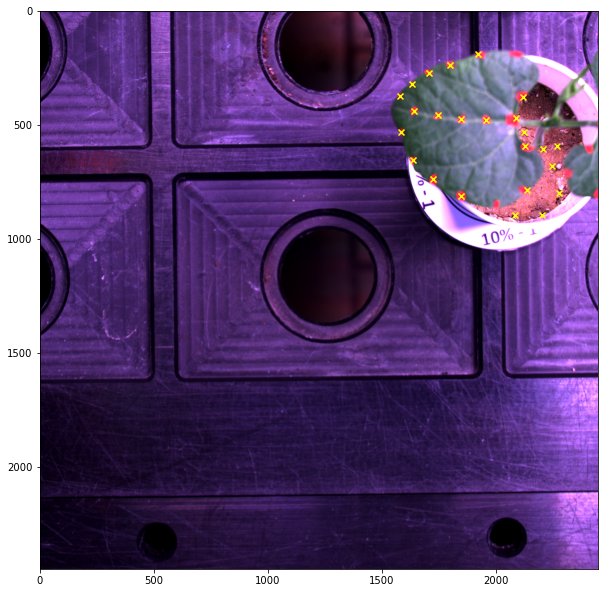

In [14]:
plt.figure(figsize=(10,20))
plt.imshow(image_1)
X = [c[1]for c in red_dot_image_1]
Y = [c[0]for c in red_dot_image_1]
plt.scatter(X,Y,color='yellow', marker = 'x')

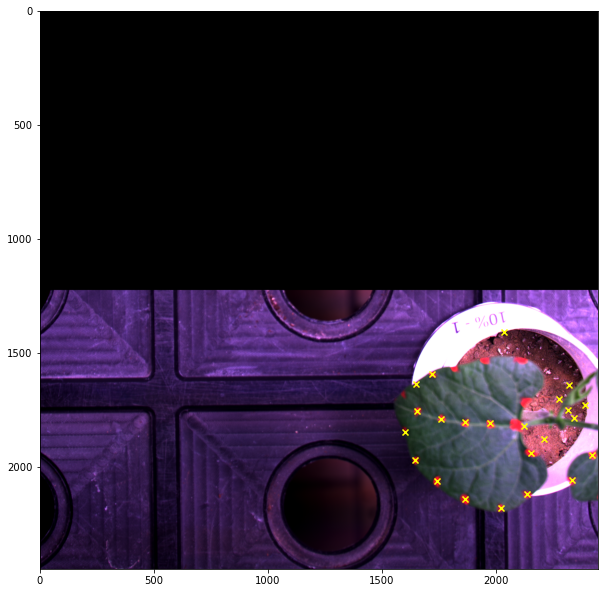

In [17]:
plt.figure(figsize=(10,20))
plt.imshow(image_2)
X = [c[1]for c in red_dot_image_2]
Y = [c[0]for c in red_dot_image_2]
plt.scatter(X,Y,color='yellow', marker = 'x')

In [16]:
coords_pred

NameError: name 'coords_pred' is not defined

In [29]:
mean_image_1 = np.mean(np.array(red_dot_image_1), axis=0)
print("X image_1:", mean_image_1[1]) # X-coordinaat
print("Y image_1:",mean_image_1[0]) # Y-coordinaat
print("")
mean_image_2 = np.mean(np.array(red_dot_image_2), axis=0)
print("X image_2:", mean_image_2[1]) # X-coordinaat
print("Y image_2:",mean_image_2[0]) # Y-coordinaat

X image_1: 1938.2895033779926
Y image_1: 549.9738661042198

X image_2: 2025.6805361368597
Y image_2: 1842.2585604288572


# Zwaartepunt red dots

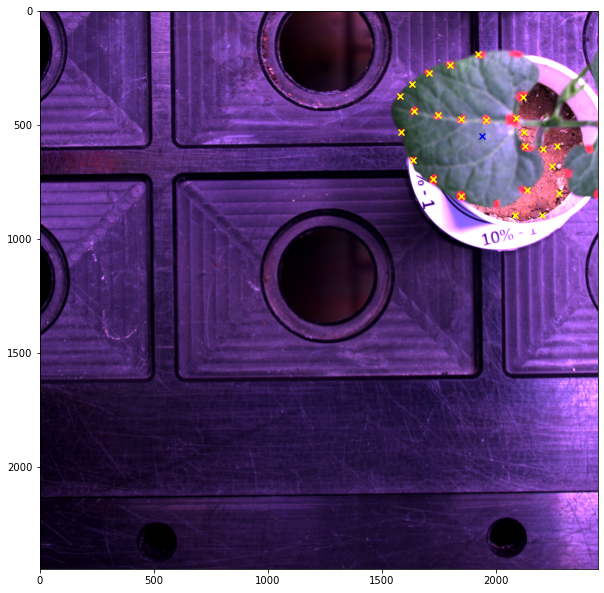

In [52]:
plt.figure(figsize=(10,20))
plt.imshow(image_1)
X = [c[1]for c in red_dot_image_1]
Y = [c[0]for c in red_dot_image_1]
plt.scatter(X,Y,color='yellow', marker="x")
plt.scatter([mean_image_1[1]],[mean_image_1[0]],color='blue', marker = 'x')

In [ ]:
np.array(coords_pred)

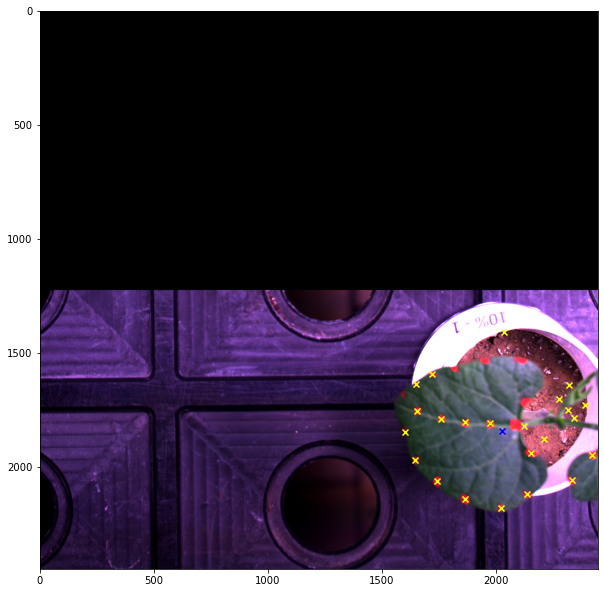

In [39]:
# Plot image 2 met red_dots en center
plt.figure(figsize=(10,20))
plt.imshow(image_2)
X = [c[1]for c in red_dot_image_2]
Y = [c[0]for c in red_dot_image_2]
plt.scatter(X, Y, color='yellow', marker="x")
plt.scatter([mean_image_2[1]],[mean_image_2[0]],color='blue', marker = 'x')

X center_image_1: 1938.2895033779926
Y center_image_1: 549.9738661042198

X center_image_2: 2025.6805361368597
Y center_image_2: 1842.2585604288572


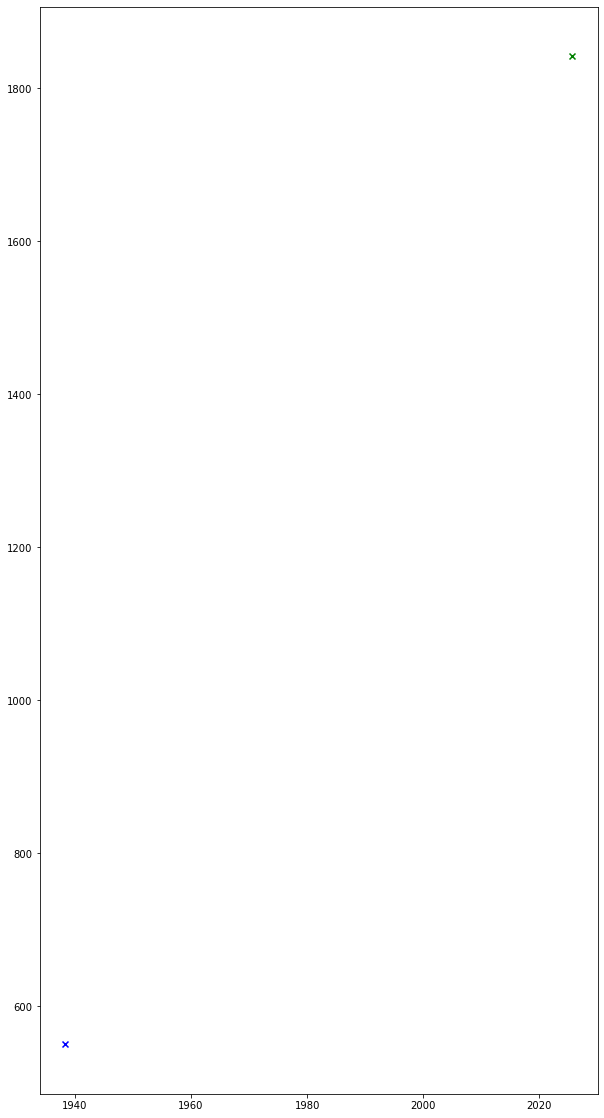

In [48]:
# Print center image 1 + image 2
print("X center_image_1:", mean_image_1[1]) # X-coordinaat center image 1
print("Y center_image_1:", mean_image_1[0]) # Y-coordinaat center image 1
print("")
print("X center_image_2:", mean_image_2[1]) # X-coordinaat center image 2
print("Y center_image_2:", mean_image_2[0]) # Y-coordinaat center image 2
plt.figure(figsize=(10,20))
plt.scatter([mean_image_1[1]],[mean_image_1[0]],color='blue', marker = 'x')
plt.scatter([mean_image_2[1]],[mean_image_2[0]],color='green', marker = 'x')

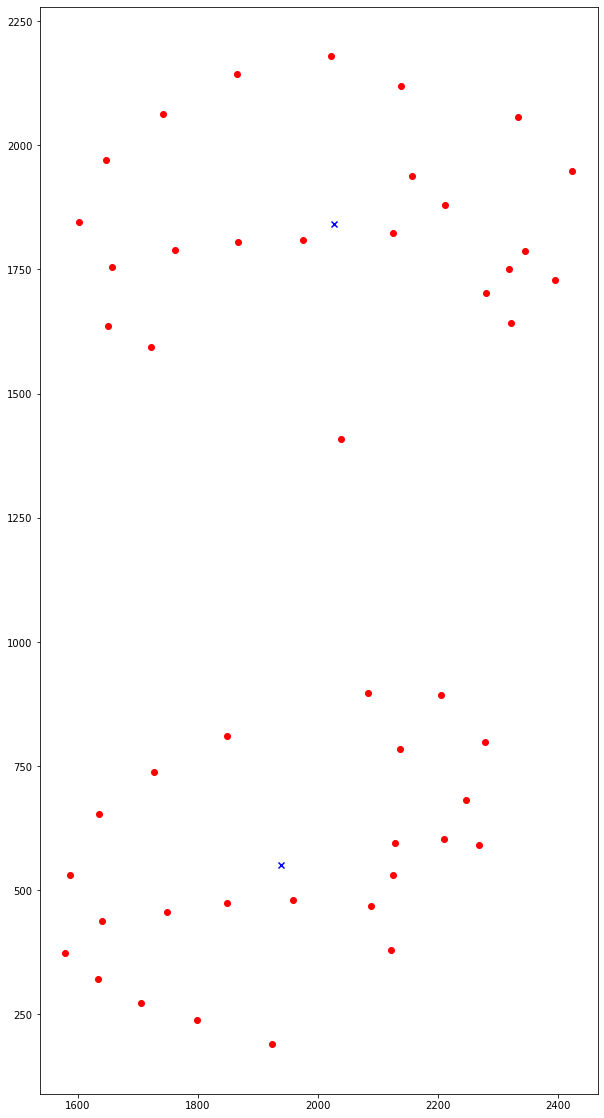

In [55]:
# Red dots + centers plot
plt.figure(figsize=(10,20))
X_image_1 = [c[1]for c in red_dot_image_1]
Y_image_1 = [c[0]for c in red_dot_image_1]
X_image_2 = [c[1]for c in red_dot_image_2]
Y_image_2 = [c[0]for c in red_dot_image_2]
plt.scatter(X_image_1, Y_image_1, color='red')
plt.scatter(X_image_2, Y_image_2, color='red')
plt.scatter([mean_image_1[1]],[mean_image_1[0]],color='blue', marker = 'x')
plt.scatter([mean_image_2[1]],[mean_image_2[0]],color='blue', marker = 'x')

In [86]:
#Verschil in X- en Y-coordinaten center (image_2 - image_1)
diff_center_X = mean_image_2[1] - mean_image_1[1]
diff_center_Y = mean_image_2[0] - mean_image_1[0]
#print(diff_center_X, diff_center_Y)

X_mean_image_1_correction = mean_image_1[1] + diff_center_X
Y_mean_image_1_correction = mean_image_1[0] + diff_center_Y

print(X_mean_image_1_correction)
print(Y_mean_image_1_correction)


2025.6805361368597
1842.258560428857


In [87]:
X_image_1_correction = X_image_1 + diff_center_X
Y_image_1_correction = Y_image_1 + diff_center_Y
print(X_image_1_correction)
print(Y_image_1_correction)

[2010.7081419  1885.62931068 1792.73630602 1720.42710942 2208.94869897
 1665.95323655 1726.90083086 2175.6402423  1836.4483275  1935.70818701
 2044.89253878 1673.71775608 2212.77938776 2355.64123641 2215.31180571
 2296.87224738 1722.93859153 2333.3633861  1813.53952351 2365.02989882
 2223.39103276 1936.42190296 2170.9421355  2292.39103276]
[1482.06542195 1530.47608392 1565.36002667 1613.97691529 1671.34269975
 1665.32675594 1729.87139266 1760.18207863 1747.87181777 1765.99613049
 1772.7831883  1823.70018063 1823.23268754 1883.44936324 1886.67020157
 1895.95530678 1945.51362742 1974.22468084 2030.79443142 2090.30729087
 2076.28469432 2103.27448528 2189.26129465 2186.28469432]


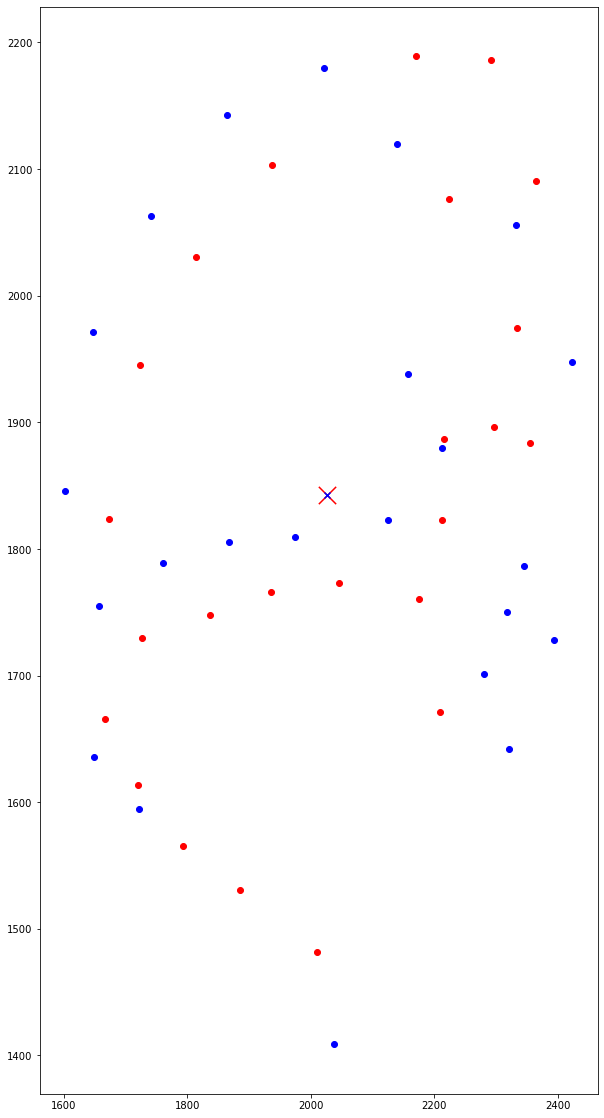

In [99]:
# Red dots + centers plot (overlap)
plt.figure(figsize=(10,20))
plt.scatter(X_image_1_correction, Y_image_1_correction, color='red')
plt.scatter(X_image_2, Y_image_2, color='blue')
plt.scatter(X_mean_image_1_correction,Y_mean_image_1_correction,color='red', marker = "x", s = 300)
plt.scatter([mean_image_2[1]],[mean_image_2[0]],color='blue', marker = 'x')
plt.savefig('overlap.jpg')